In [1]:
import pandas as pd
import cmdstanpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("./Data/input_data.csv")

In [3]:
data.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2016-01-03,India,Afghanistan,2,1,SAFF Cup,Thiruvananthapuram,India,False
1,2016-01-06,Rwanda,Cameroon,1,1,Friendly,Gisenyi,Rwanda,False
2,2016-01-06,Sweden,Estonia,1,1,Friendly,Abu Dhabi,United Arab Emirates,True
3,2016-01-08,Bangladesh,Sri Lanka,4,2,Friendly,Jessore,Bangladesh,False
4,2016-01-08,Trinidad and Tobago,Haiti,0,1,Copa América qualification,Panama City,Panama,True


In [4]:
games_played = data["home_team"].value_counts() + data["away_team"].value_counts()

In [5]:
teams = games_played.index.to_series().reset_index(drop=True)

In [6]:
nteams = len(teams)
nteams

272

In [7]:
prior_score_att_mag = data.groupby("home_team")["home_score"].sum() + data.groupby("away_team")["away_score"].sum()
prior_score_def_mag =  data.groupby("home_team")["away_score"].sum() + data.groupby("away_team")["home_score"].sum()

prior_score_att_rel = prior_score_att_mag / games_played
prior_score_def_rel = prior_score_def_mag / games_played

prior_score_att = (prior_score_att_rel - np.mean(prior_score_att_rel))/(1.5*np.std(prior_score_att_rel, ddof=1))
prior_score_def = (prior_score_def_rel - np.mean(prior_score_def_rel))/(1.5*np.std(prior_score_def_rel, ddof=1))

In [8]:
prior_score_att.sort_values(ascending=False)

Isle of Man           3.780957
Yorkshire             2.671067
Parishes of Jersey    2.466164
Jersey                2.152407
Cascadia              2.056359
                        ...   
Gotland                    NaN
Kernow                     NaN
Monaco                     NaN
Surrey                     NaN
Vatican City               NaN
Length: 272, dtype: float64

In [9]:
prior_score_def.sort_values(ascending=False)

Tuvalu            3.019104
Tonga             2.888711
Saint Helena      2.627924
Samoa             2.627924
Chagos Islands    2.517287
                    ...   
Gotland                NaN
Kernow                 NaN
Monaco                 NaN
Surrey                 NaN
Vatican City           NaN
Length: 272, dtype: float64

In [10]:
ngames = len(data)
ngames

4514

In [11]:
team1 = data.loc[:, "home_team"]
score1 = data.loc[:, "home_score"]

team2 = data.loc[:, "away_team"]
score2 = data.loc[:, "away_score"]

In [12]:
prior_score = prior_score_att.copy()
prior_score[:] = 0

In [21]:
stan_code = """
data{
  int nteams;
  int ngames;
  int team1[ngames];
  int team2[ngames];
  int score1[ngames];
  int score2[ngames];
  vector[nteams] prior_score_att;
  vector[nteams] prior_score_def;
  //vector[nteams] prior_score;
}
parameters{
  //real b;
  real<lower=0.5> c;
  real<lower=0.5> d;
  
  vector[nteams] e_att;
  vector[nteams] e_def;
  
  real<lower=0> sigma_att;
  real<lower=0> sigma_def;
  
  //real mu;
  real mu_att;
  
  real mu_def;
  
}
transformed parameters{
  vector[ngames] theta1_log;
  vector[ngames] theta2_log;
  
  vector[nteams] att;
  vector[nteams] def;
  
  
  for(t in 1:nteams){
    att[t] = +mu_att
             +c*prior_score_att[t]
             //+b*prior_score[t]
             +sigma_att*e_att[t];
    
    def[t] = -mu_def
             -d*prior_score_def[t]
             +sigma_def*e_def[t];
             //-b*prior_score[t];
    }
  
  for (n in 1:ngames){
    theta1_log[n] = +att[team1[n]]
                    +def[team2[n]];

    theta2_log[n] = +att[team2[n]]
                    +def[team1[n]]; 
  }
}
model{
    score1 ~ poisson_log(theta1_log);
    score2 ~ poisson_log(theta2_log);
  
    e_att ~ normal(0,1);
    e_def ~ normal(0,1);
    
    mu_att ~ normal(0,1);
    mu_def ~ normal(0,1);
    
    sigma_att ~ student_t(3, 0, 3);
    sigma_def ~ student_t(3, 0, 3);
}
generated quantities{
    int score1_rep[ngames];
    int score2_rep[ngames];

  
  
    for (n in 1:ngames){
        score1_rep[n] = poisson_log_rng(theta1_log[n]);
        score2_rep[n] = poisson_log_rng(theta2_log[n]);
    }
  
}
"""

In [22]:
import os
import pickle
import gzip


In [23]:
from hashlib import md5

In [24]:
md5_str = md5(stan_code.encode("utf-8")).hexdigest()

In [25]:
cmdstanpy.CmdStanModel

cmdstanpy.model.CmdStanModel

In [26]:
stan_file = "euro_2021_2.stan"
with open(stan_file, "w") as f:
    print(stan_code, file=f)

In [27]:
%time stan_model = cmdstanpy.CmdStanModel(model_name="euro_2021", stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: C:/Users/harti/Dropbox/Ari/Euro2021/euro_2021_2.exe
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: C:/Users/harti/Dropbox/Ari/Euro2021/euro_2021_2.exe


Wall time: 42 s


In [28]:
prior_score_att.isnull().sum()

9

In [29]:
teams_order = prior_score.copy()
teams_order[:] = np.arange(1, teams_order.shape[0]+1)

In [30]:
teams_order

Abkhazia           1
Afghanistan        2
Albania            3
Alderney           4
Algeria            5
                ... 
Yorkshire        268
Zambia           269
Zanzibar         270
Zimbabwe         271
Åland Islands    272
Length: 272, dtype: int32

In [31]:
team1_ = team1.apply(lambda x: teams_order.loc[x])
team2_ = team2.apply(lambda x: teams_order.loc[x])

In [32]:
prior_score_ = prior_score[teams_order.index].fillna(0)
prior_score_att_ = prior_score_att[teams_order.index].fillna(prior_score_att.min()-0.5)
prior_score_def_ = prior_score_def[teams_order.index].fillna(prior_score_def.max()+0.5)

In [33]:
stan_data = dict(
    nteams = nteams,
    ngames = ngames,
    
    team1 = team1_.values.tolist(),
    score1 = score1.values.tolist(),
    
    team2 = team2_.values.tolist(),
    score2 = score2.values.tolist(),
    
    prior_score_att = prior_score_att_.values.tolist(),
    prior_score_def = prior_score_def_.values.tolist(),
    #prior_score = prior_score_.values.tolist(),
)

In [35]:
import json
with open("euro_2021_2.json", "w") as f:
    json.dump(stan_data, f)

In [36]:
%%time
fit = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [27:02<00:00,  6.16it/s]


Wall time: 27min 8s


In [37]:
%%time
fit2 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [23:20<00:00,  7.14it/s]


Wall time: 23min 26s


In [38]:
%%time
fit3 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [22:52<00:00,  7.28it/s]


Wall time: 22min 59s


In [39]:
%%time
fit4 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [23:34<00:00,  7.07it/s]


Wall time: 23min 41s


In [40]:
%%time
fit5 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [23:35<00:00,  7.06it/s]


Wall time: 23min 42s


In [41]:
%%time
fit6 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [23:08<00:00,  7.20it/s]


Wall time: 23min 14s


In [42]:
%%time
fit7 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [23:22<00:00,  7.13it/s]


Wall time: 23min 29s


In [43]:
%%time
fit8 = stan_model.sample(data="euro_2021_2.json", iter_warmup=5000, iter_sampling=5000, chains=1, show_progress=True)

Chain 1 -   done: 100%|█████████████████████| 10000/10000 [23:17<00:00,  7.16it/s]


Wall time: 23min 23s


In [44]:
matches = pd.concat((team1, team2), axis=1).apply(lambda x: " - ".join(x), axis=1).tolist()

In [45]:
import arviz as az

In [46]:
%%time
idata = az.concat(
    [
        az.from_cmdstanpy(
            posterior=fit_, 
            posterior_predictive=["score1_rep", "score2_rep"], 
            dtypes=stan_model, 
            coords={"team": teams_order.index.tolist(), "match": matches},
            dims={
                "att": ["team"],
                "def": ["team"],
                "e_att": ["team"],
                "e_def": ["team"],
                "theta1_log": ["match"],
                "theta2_log": ["match"],
                "score1_rep": ["match"],
                "score2_rep": ["match"]
            }) for fit_ in [fit, fit2, fit3, fit4, fit5, fit6, fit7, fit8]
    ], 
    dim="chain")

Wall time: 8min 3s


In [47]:
idata.to_netcdf("euro_2021_2_posterior.nc")

'euro_2021_2_posterior.nc'

In [48]:
with open("euro2021_matches.json", "r") as f:
    new_data = json.load(f)

In [49]:
euro_teams = new_data["teams"]

In [50]:
euro_teams

['Ukraine',
 'Czech Republic',
 'Spain',
 'Denmark',
 'Belgium',
 'Poland',
 'France',
 'Slovakia',
 'Sweden',
 'Croatia',
 'Turkey',
 'Hungary',
 'Finland',
 'Wales',
 'Netherlands',
 'Russia',
 'Austria',
 'Scotland',
 'Germany',
 'Switzerland',
 'Italy',
 'England',
 'Portugal',
 'North Macedonia']

In [51]:
att_summary = az.summary(idata.posterior["att"].sel(indexers={"team": euro_teams}))
def_summary = az.summary(idata.posterior["def"].sel(indexers={"team": euro_teams}))

In [52]:
att_summary.sort_values(by="mean", ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
att[Belgium],1.265,0.721,-0.121,2.604,0.003,0.003,42472.0,31110.0,1.0
att[Spain],1.249,0.722,-0.108,2.607,0.003,0.003,42500.0,31211.0,1.0
att[Germany],1.170,0.721,-0.223,2.496,0.003,0.003,42496.0,31085.0,1.0
att[France],1.100,0.722,-0.237,2.488,0.004,0.003,42311.0,31063.0,1.0
att[Netherlands],1.073,0.723,-0.294,2.441,0.004,0.003,42650.0,30681.0,1.0
att[Portugal],1.037,0.722,-0.311,2.421,0.003,0.003,42634.0,30883.0,1.0
att[England],1.004,0.722,-0.349,2.381,0.003,0.003,42673.0,31580.0,1.0
att[Italy],0.931,0.723,-0.419,2.303,0.004,0.003,42475.0,30401.0,1.0
att[Denmark],0.883,0.723,-0.523,2.205,0.003,0.003,42898.0,31318.0,1.0
att[Croatia],0.837,0.724,-0.536,2.196,0.004,0.003,42725.0,31089.0,1.0


In [53]:
order_att = att_summary.sort_values(by="mean", ascending=True).index.to_series().apply(lambda x: x.replace("att[", "").replace("]", "")).tolist()

INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017160E4ADD8>],
      dtype=object)

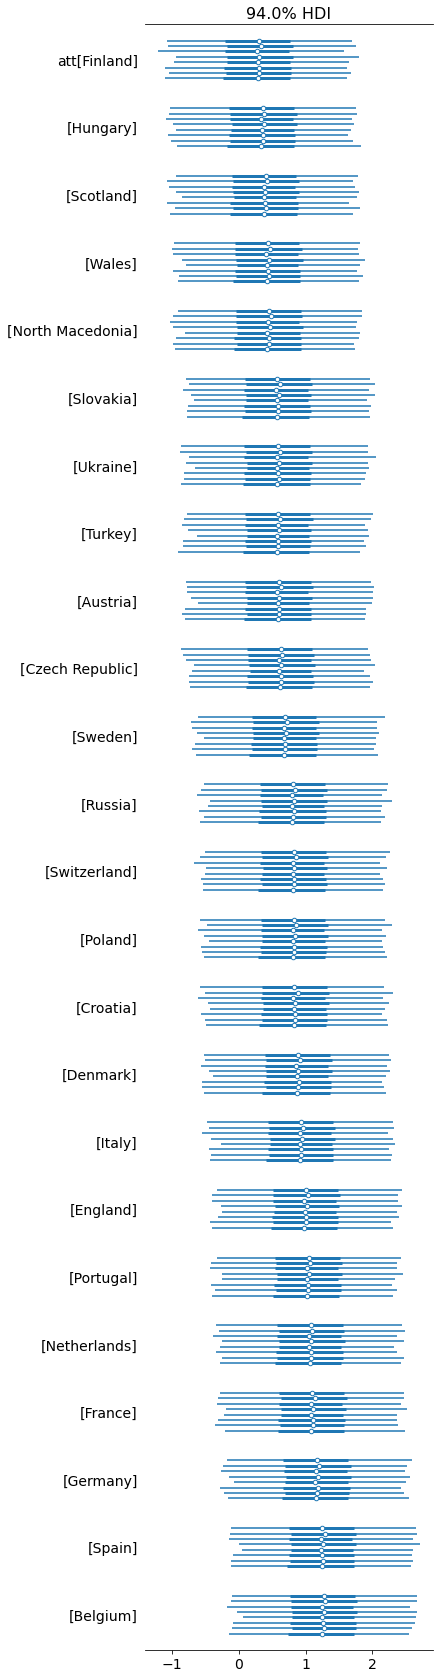

In [54]:
az.plot_forest(idata.posterior["att"].sel(indexers={"team": order_att}))

In [55]:
def_summary.sort_values(by="mean", ascending=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
def[Italy],-1.120,0.734,-2.489,0.274,0.004,0.003,43881.0,32181.0,1.0
def[England],-0.996,0.730,-2.368,0.390,0.003,0.003,43796.0,31233.0,1.0
def[Denmark],-0.941,0.735,-2.280,0.488,0.004,0.003,43572.0,31654.0,1.0
def[Portugal],-0.941,0.730,-2.352,0.415,0.004,0.003,43190.0,30858.0,1.0
def[Spain],-0.938,0.731,-2.332,0.427,0.004,0.003,43008.0,31719.0,1.0
def[France],-0.866,0.729,-2.236,0.523,0.003,0.003,43451.0,31211.0,1.0
def[Belgium],-0.745,0.730,-2.151,0.607,0.004,0.003,43311.0,31197.0,1.0
def[Netherlands],-0.723,0.731,-2.117,0.644,0.004,0.003,43066.0,31358.0,1.0
def[Switzerland],-0.712,0.728,-2.058,0.693,0.004,0.003,43242.0,31853.0,1.0
def[Sweden],-0.706,0.727,-2.096,0.650,0.004,0.003,43047.0,30919.0,1.0


In [56]:
order_def = def_summary.sort_values(by="mean", ascending=True).index.to_series().apply(lambda x: x.replace("def[", "").replace("]", "")).tolist()

INFO:numba.core.transforms:finding looplift candidates


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000171654CCC50>],
      dtype=object)

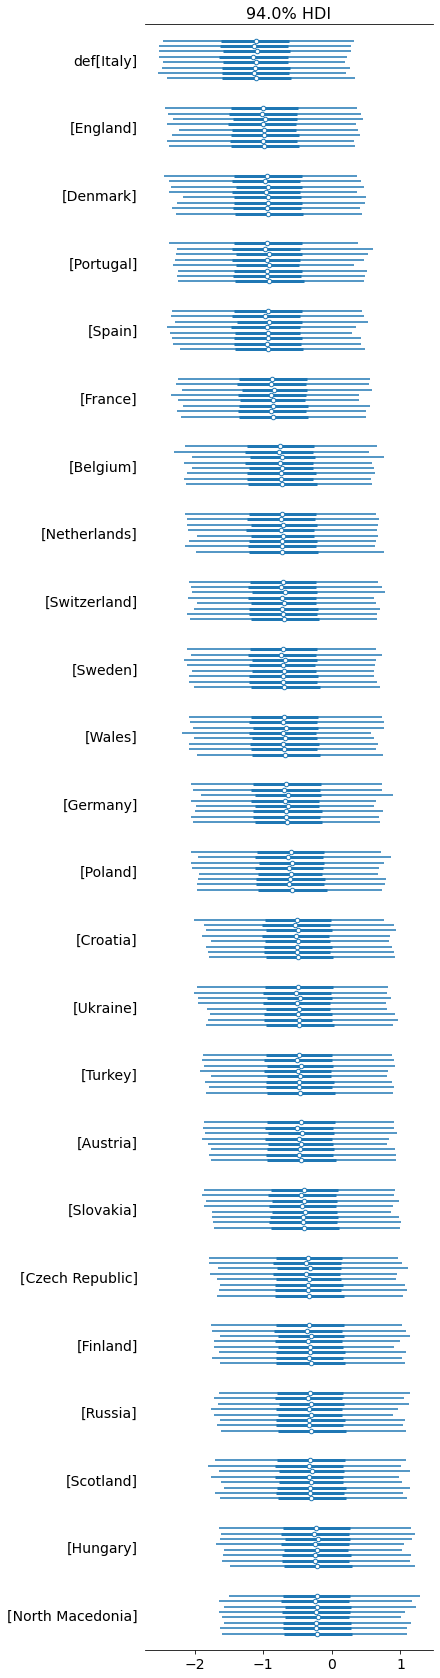

In [57]:
az.plot_forest(idata.posterior["def"].sel(indexers={"team": order_def}))

In [58]:
euro_matches = []
euro_matches_stats = []
for match in new_data["match"]:
    teamA = match["teamA"]
    teamB = match["teamB"]
    
    att_teamA = idata.posterior["att"].sel(indexers={"team": teamA})
    att_teamB = idata.posterior["att"].sel(indexers={"team": teamB})

    def_teamA = idata.posterior["def"].sel(indexers={"team": teamA})
    def_teamB = idata.posterior["def"].sel(indexers={"team": teamB})
    
    theta1_log = att_teamA + def_teamB
    theta2_log = att_teamB + def_teamA
    
    score1 = np.random.poisson(np.exp(theta1_log))
    score2 = np.random.poisson(np.exp(theta2_log))
    
    team1_win, draw, team2_win = (score1 > score2).mean(), (score1 == score2).mean(), (score1 < score2).mean()
    euro_matches.append({"teamA": teamA, "teamB": teamB, "score1": score1, "score2": score2})
    euro_matches_stats.append({"teamA": teamA, "teamB": teamB, "team1_win": team1_win, "draw": draw, "team2_win": team2_win})

In [59]:
euro_stats = pd.DataFrame(euro_matches_stats)

In [60]:
points = {}
for team, res in euro_stats.groupby("teamA"):
    if team not in points:
        points[team] = 0
    points[team] += np.sum(res.loc[:, ["team1_win", "draw"]] * np.array([3, 1])).sum()

for team, res in euro_stats.groupby("teamB"):
    if team not in points:
        points[team] = 0
    points[team] += np.sum(res.loc[:, ["team2_win", "draw"]] * np.array([3, 1])).sum()

In [61]:
gathered_points = pd.Series(points).sort_values(ascending=False)

In [62]:
groups = {
    "A": ["Turkey", "Italy", "Wales", "Switzerland"],
    "B": ["Denmark", "Finland", "Belgium", "Russia"],
    "C": ["Netherlands", "Ukraine", "Austria", "North Macedonia"],
    "D": ["England", "Croatia", "Czech Republic", "Scotland"],
    "E": ["Spain", "Sweden", "Poland", "Slovakia"],
    "F": ["Portugal", "France", "Germany", "Hungary"],
}

In [63]:
for group_letter, group_teams in groups.items():
    print(f"Group {group_letter}")
    print(gathered_points[group_teams].sort_values(ascending=False).round(2).to_string())
    print()

Group A
Italy          5.79
Switzerland    4.37
Wales          3.18
Turkey         2.94

Group B
Belgium    6.28
Denmark    5.41
Russia     3.21
Finland    1.84

Group C
Netherlands        6.34
Ukraine            3.87
Austria            3.81
North Macedonia    2.55

Group D
England           6.46
Croatia           4.48
Czech Republic    3.22
Scotland          2.45

Group E
Spain       6.43
Poland      3.86
Sweden      3.74
Slovakia    2.52

Group F
Portugal    5.32
France      5.32
Germany     4.93
Hungary     1.20



In [64]:
goals_scored = {}
goals_letin = {}
for match in euro_matches:
    teamA = match["teamA"]
    teamB = match["teamB"]
    
    if teamA not in goals_scored:
        goals_scored[teamA] = 0
    if teamA not in goals_letin:
        goals_letin[teamA] = 0
        
    if teamB not in goals_scored:
        goals_scored[teamB] = 0
    if teamB not in goals_letin:
        goals_letin[teamB] = 0
    
    #goal_countA, goalsA = np.unique(match["score1"].ravel(), return_counts=True)
    #goal_countB, goalsB = np.unique(match["score2"].ravel(), return_counts=True)
    
    #goals_teamA = dict(zip(goal_countA, goalsA/sum(goalsA)))
    #goals_teamB = dict(zip(goal_countB, goalsB/sum(goalsB)))
    
    goals_scored[teamA] += match["score1"].mean()
    goals_letin[teamA] += match["score2"].mean()
    
    goals_scored[teamB] += match["score2"].mean()
    goals_letin[teamB] += match["score1"].mean()

In [65]:
goals_stats= pd.concat((pd.Series(goals_scored).sort_values(ascending=False).round(2), pd.Series(goals_letin).sort_values(ascending=False).round(2)), axis=1)
goals_stats.columns = ["Scored", "Let-in"]

In [66]:
goals_stats

,Scored,Let-in
Belgium,6.60,2.90
Netherlands,6.05,2.55
Spain,6.00,2.41
England,5.62,2.12
Germany,5.24,3.78
France,5.17,3.18
Portugal,4.94,3.02
Denmark,4.71,2.84
Croatia,4.23,3.71
Italy,4.14,1.87


In [67]:
match_res = []
for match in euro_matches:
    home_goals, visitor_goals = np.meshgrid(np.arange(0, 20), np.arange(0, 20))
    prob = np.zeros_like(home_goals)
    for item, item2 in zip(match["score1"].ravel(), match["score2"].ravel()):
        prob[item, item2] += 1
    prob = (prob / prob.sum())
    match_res.append({"teamA": match["teamA"], "teamB": match["teamB"], "result": prob})

In [68]:
from pathlib import Path

In [69]:
for k, match in enumerate(match_res, 1):
    plt.figure(figsize=(6,6), dpi=100)
    plt.imshow(match["result"])
    plt.xlim(-0.5,6.5)
    plt.ylim(-0.5,6.5)

    plt.ylabel(f"Goals {match['teamA']}")
    plt.xlabel(f"Goals {match['teamB']}")

    plt.title(f"{match['teamA']} - {match['teamB']}")

    for i, row in enumerate((match["result"] * 100).round(0)):
        if i > 6:
            continue
        for j, item in enumerate(row):
            if j > 6:
                continue
            plt.text(i, j, horizontalalignment='center', verticalalignment='center',
                     s=f'{round(100*match["result"][j, i])}%', color="k" if match["result"][j, i]/match["result"].max() > 0.35 else plt.cm.viridis_r(match["result"][j, i]/match["result"].max()))
    pred_res = Path("./Predictions2")
    pred_res.mkdir(exist_ok=True, parents=True)
    print(f"{k:>02d}. {match['teamA']} - {match['teamB']}")
    plt.savefig(pred_res / f"{k:>02d}. {match['teamA']} - {match['teamB']}.png", dpi=300)
    plt.close()

01. Turkey - Italy
02. Wales - Switzerland
03. Turkey - Wales
04. Italy - Switzerland
05. Italy - Wales
06. Switzerland - Turkey
07. Denmark - Finland
08. Belgium - Russia
09. Finland - Russia
10. Denmark - Belgium
11. Finland - Belgium
12. Russia - Denmark
13. Austria - North Macedonia
14. Netherlands - Ukraine
15. Ukraine - North Macedonia
16. Netherlands - Austria
17. Ukraine - Austria
18. North Macedonia - Netherlands
19. England - Croatia
20. Scotland - Czech Republic
21. Croatia - Czech Republic
22. England - Scotland
23. Czech Republic - England
24. Croatia - Scotland
25. Poland - Slovakia
26. Spain - Sweden
27. Sweden - Slovakia
28. Spain - Poland
29. Sweden - Poland
30. Slovakia - Spain
31. Hungary - Portugal
32. France - Germany
33. Hungary - France
34. Portugal - Germany
35. Germany - Hungary
36. Portugal - France


# Calculate order probabilities

In [82]:
points = {}
for match in euro_matches:
    teamA_wins = match["score1"] > match["score2"]
    draw = match["score1"] == match["score2"]
    teamB_wins = match["score1"] < match["score2"]
    if match["teamA"] not in points:
        points[match["teamA"]] = np.zeros_like(draw.ravel(), dtype=float)
    if match["teamB"] not in points:
        points[match["teamB"]] = np.zeros_like(draw.ravel(), dtype=float)
    
    points[match["teamA"]] += (teamA_wins.astype(float) * 3).ravel()
    points[match["teamA"]] += (draw.astype(float) * 1).ravel()
    
    points[match["teamB"]] += (teamB_wins.astype(float) * 3).ravel()
    points[match["teamB"]] += (draw.astype(float) * 1).ravel()

In [88]:
points_df = pd.DataFrame(points)

In [164]:
points_df.shape

(40000, 24)

In [165]:
ranks = {}
for group_letter, group_teams in groups.items():
    ranks[group_letter] = {key: (-points_df[group_teams]).rank(method="first", axis=1).astype(int)[key].value_counts()/points_df.shape[0] for key in group_teams}

In [169]:
ranks["B"]["Finland"] * 100

4    54.985
3    32.115
2     9.960
1     2.940
Name: Finland, dtype: float64

In [203]:
for i, match in enumerate(euro_matches_stats):
    if (i % 10) == 0:
        print("\n"*3)
        print(f"{'Team A':>15} - {'Team B':<15}     {'1':<8}{'X'}{'2':>8}")
        
    print(f"{match['teamA']:>15} - {match['teamB']:<15}     {round(match['team1_win'] * 100,1):<8}{round(match['draw'] * 100,1)}{round(match['team2_win'] * 100,1):>8}")





         Team A - Team B              1       X       2
         Turkey - Italy               14.1    24.8    61.2
          Wales - Switzerland         24.9    30.2    44.9
         Turkey - Wales               32.2    32.0    35.8
          Italy - Switzerland         48.5    29.0    22.6
          Italy - Wales               55.9    29.2    14.9
    Switzerland - Turkey              49.4    26.8    23.8
        Denmark - Finland             67.3    22.1    10.6
        Belgium - Russia              69.5    16.4    14.1
        Finland - Russia              22.9    24.6    52.5
        Denmark - Belgium             31.3    26.1    42.6




         Team A - Team B              1       X       2
        Finland - Belgium             7.6     14.1    78.2
         Russia - Denmark             19.0    23.2    57.8
        Austria - North Macedonia     48.1    25.9    25.9
    Netherlands - Ukraine             58.8    22.9    18.3
        Ukraine - North Macedonia     48.3    26.5    

In [204]:
for i, match in enumerate(match_res):
    break

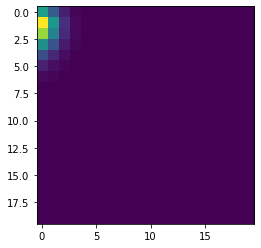

In [407]:
plt.imshow(match_res[6]["result"])

In [416]:
with open("goal_results.txt", "w") as f:
    for i, match in enumerate(match_res):
        props = []
        probs = []
        for s2 in range(0, 20-4):
            for e2 in range(s2+1, s2+5):
                for s1 in range(0, 20-5):
                    for e1 in range(s1+1, s1+5-(e2-s2)):
                        prob = match["result"][s1:e1+1, s2:e2+1].sum()
                        prop = (s1, e1, s2, e2)
                        if ((prop[1]+1 - prop[0]) * (prop[3]+1 - prop[2])) > 4:
                            continue
                        if prob > 0:
                            probs.append(prob)
                            props.append(prop)
        res = pd.concat((pd.DataFrame(probs), pd.DataFrame(props)), axis=1)
        res.columns = ["prob", "s1", "e1", "s2", "e2"]
        res = res.sort_values(by="prob", ascending=False)
        print(f"{match['teamA']:>15} - {match['teamB']:<15}     {int(res.iloc[0]['s1'])}..{int(res.iloc[0]['e1'])} - {int(res.iloc[0]['s2'])}..{int(res.iloc[0]['e2'])}    {round(res.iloc[0]['prob']*100, 1)}%")
        for i in range(1,3):
            print(f"{'':>15}   {'':<15}     {int(res.iloc[i]['s1'])}..{int(res.iloc[i]['e1'])} - {int(res.iloc[i]['s2'])}..{int(res.iloc[i]['e2'])}    {round(res.iloc[i]['prob']*100, 1)}%")
        print()

        print(f"{match['teamA']:>15} - {match['teamB']:<15}     {int(res.iloc[0]['s1'])}..{int(res.iloc[0]['e1'])} - {int(res.iloc[0]['s2'])}..{int(res.iloc[0]['e2'])}    {round(res.iloc[0]['prob']*100, 1)}%", file=f)
        for i in range(1,3):
            print(f"{'':>15}   {'':<15}     {int(res.iloc[i]['s1'])}..{int(res.iloc[i]['e1'])} - {int(res.iloc[i]['s2'])}..{int(res.iloc[i]['e2'])}    {round(res.iloc[i]['prob']*100, 1)}%", file=f)
        print(file=f)

         Turkey - Italy               0..1 - 1..2    50.4%
                                      0..1 - 0..1    46.6%
                                      0..1 - 2..3    33.7%

          Wales - Switzerland         0..1 - 0..1    55.2%
                                      0..1 - 1..2    46.1%
                                      1..2 - 0..1    33.2%

         Turkey - Wales               0..1 - 0..1    57.0%
                                      0..1 - 1..2    41.5%
                                      1..2 - 0..1    39.0%

          Italy - Switzerland         0..1 - 0..1    53.0%
                                      1..2 - 0..1    47.4%
                                      0..1 - 1..2    30.9%

          Italy - Wales               0..1 - 0..1    57.5%
                                      1..2 - 0..1    52.2%
                                      2..3 - 0..1    29.0%

    Switzerland - Turkey              0..1 - 0..1    45.2%
                                      1..2 - 0..1  

In [412]:
match["result"][0:1+1, 0:1+1].sum()

0.430875

         Turkey - Italy               0..0 - 1..0    50.4%
                                      0..0 - 0..0    46.6%
                                      0..0 - 2..0    33.7%

